In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv(r"C:\Users\vvaib\Downloads\k8s_metrics.csv")
df = df.drop('API Latency', axis=1)
df = df.drop('Pod Name', axis=1)

# Encode Pod Status: Running=0, Others=1

df['Anomaly'] = (df['Node Status'] != "Running").astype(int)

# Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values('Timestamp')
df['hour'] = df['Timestamp'].dt.hour
df['minute'] = df['Timestamp'].dt.minute
df['dayofweek'] = df['Timestamp'].dt.dayofweek



last_max_memory = None
threshold = 20  

for i in range(1, len(df)):  # Start from index 1 to access previous row
    if df.loc[i, "Memory Usage"] < threshold and df.loc[i, "Node Status"] != "Running":
        df.loc[i, "Memory Usage"] = df.loc[i - 1, "Memory Usage"]  # Map to previous value


# Normalize numerical columns
scaler = MinMaxScaler()
df[['CPU Load', 'Memory Usage']] = scaler.fit_transform(df[['CPU Load', 'Memory Usage']])
df[['hour', 'minute', 'dayofweek']] = scaler.fit_transform(df[['hour', 'minute', 'dayofweek']])

# Features and labels
features = df[['CPU Load', 'Memory Usage', 'hour', 'minute', 'dayofweek']].values
labels = df[['CPU Load', 'Memory Usage', 'Anomaly']].values


In [2]:
def create_sequences(X, y, window_size=5):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(features, labels)

train_size = int(len(X_seq) * 0.95)

X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]


In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout

# Input Layer
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# Shared LSTM Layer
x = LSTM(64, return_sequences=False)(input_layer)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)

# Output 1: CPU Load
cpu_output = Dense(1, name="cpu_output")(x)

# Output 2: Memory Usage
mem_output = Dense(1, name="mem_output")(x)

# Output 3: Anomaly Detection
ano_output = Dense(1, activation='sigmoid', name="ano_output")(x)

# Define the model
model = Model(inputs=input_layer, outputs=[cpu_output, mem_output, ano_output])

# Compile the model
model.compile(
    loss={
        "cpu_output": "mse",
        "mem_output": "mse",
        "ano_output": "binary_crossentropy"
    },
    optimizer="adam",
    metrics={
        "cpu_output": ["mae"],
        "mem_output": ["mae"],
        "ano_output": ["accuracy"]
    }
)

model.summary()

# Split the targets
y_train_cpu = y_train[:, 0]
y_train_mem = y_train[:, 1]
y_train_ano = y_train[:, 2]

y_test_cpu = y_test[:, 0]
y_test_mem = y_test[:, 1]
y_test_ano = y_test[:, 2]

# Fit model
history = model.fit(
    X_train,
    [y_train_cpu, y_train_mem, y_train_ano],
    epochs=20,
    batch_size=64,
    validation_data=(X_test, [y_test_cpu, y_test_mem, y_test_ano])
)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5, 5)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     17,920 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      2,080 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cpu_output (Dense)  │ (None, 1)         │         33 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mem_output (Dense)  │ (None, 1)         │         33 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ano_output (Dense)  │ (None, 1)         │         33 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 20,099 (78.51 KB)

 Trainable params: 20,099 (78.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
890/890 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - ano_output_accuracy: 0.9877 - ano_output_loss: 0.0450 - cpu_output_loss: 0.6459 - cpu_output_mae: 0.1232 - loss: 0.7208 - mem_output_loss: 0.0299 - mem_output_mae: 0.1089 - val_ano_output_accuracy: 0.9893 - val_ano_output_loss: 0.0106 - val_cpu_output_loss: 0.4945 - val_cpu_output_mae: 0.0349 - val_loss: 0.5146 - val_mem_output_loss: 0.0101 - val_mem_output_mae: 0.0519
Epoch 2/20
890/890 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - ano_output_accuracy: 0.9883 - ano_output_loss: 0.0121 - cpu_output_loss: 0.4410 - cpu_output_mae: 0.0479 - loss: 0.4589 - mem_output_loss: 0.0058 - mem_output_mae: 0.0440 - val_ano_output_accuracy: 0.9893 - val_ano_output_loss: 0.0106 - val_cpu_output_loss: 0.4939 - val_cpu_output_mae: 0.0333 - val_loss: 0.5134 - val_mem_output_loss: 0.0095 - val_mem_output_mae: 0.0491
Epoch 3/20
890/890 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - ano_output_accuracy: 0.9883 - ano_output_loss: 0.0117 - cpu_output_loss: 0.4362 - cpu_ou

In [9]:
# Evaluate the model
results = model.evaluate(X_test, [y_test_cpu, y_test_mem, y_test_ano])

print(f"CPU Load MAE: {results[3]}")
print(f"Memory Usage MAE: {results[4]}")
print(f"Anomaly Accuracy: {results[5]}")


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - ano_output_accuracy: 0.9913 - ano_output_loss: 0.0083 - cpu_output_loss: 0.4638 - cpu_output_mae: 0.0229 - loss: 0.4765 - mem_output_loss: 0.0044 - mem_output_mae: 0.0185
CPU Load MAE: 0.011502434499561787
Memory Usage MAE: 0.9856570959091187
Anomaly Accuracy: 0.030210299417376518


In [19]:
y_pred_probs  = model.predict(X_test)[2]

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [34]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Predict on test set
y_pred_ano_probs = model.predict(X_test)[2]  # Index 2 is anomaly output
y_pred_ano = (y_pred_ano_probs > 0.0001).astype(int)  # Thresholding at 0.5

# Print confusion matrix
conf_matrix = confusion_matrix(y_test_ano, y_pred_ano)
print("Confusion Matrix:\n", conf_matrix)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Confusion Matrix:
 [[1436 1530]
 [  10   22]]


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


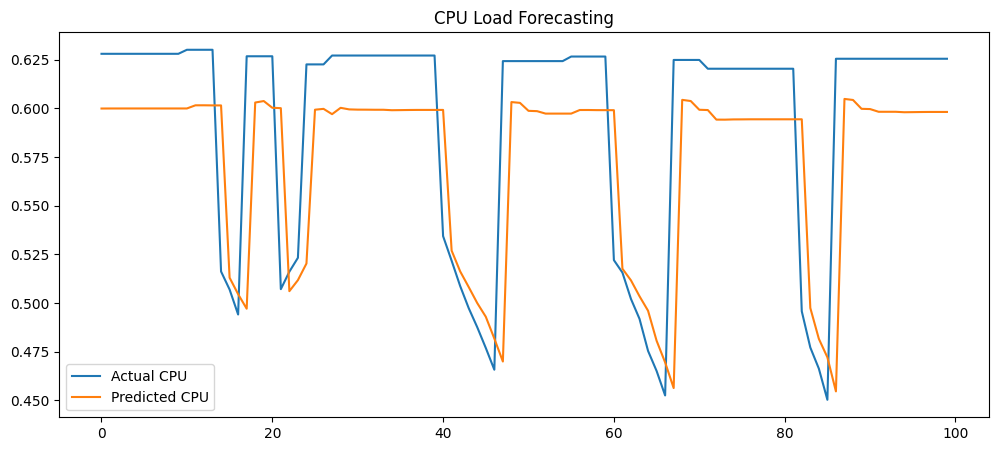

In [6]:
import matplotlib.pyplot as plt

cpu_pred = model.predict(X_test)[0]
plt.figure(figsize=(12,5))
plt.plot(y_test_cpu[:100], label='Actual CPU')
plt.plot(cpu_pred[:100], label='Predicted CPU')
plt.title('CPU Load Forecasting')
plt.legend()
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


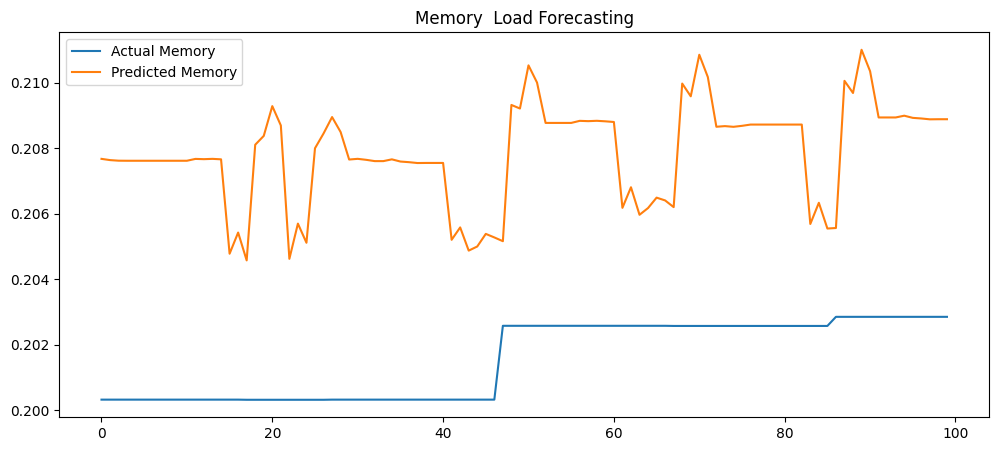

In [7]:
import matplotlib.pyplot as plt

mem_pred = model.predict(X_test)[1]
plt.figure(figsize=(12,5))
plt.plot(y_test_mem[:100], label='Actual Memory')
plt.plot(mem_pred[:100], label='Predicted Memory')
plt.title('Memory  Load Forecasting')
plt.legend()
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


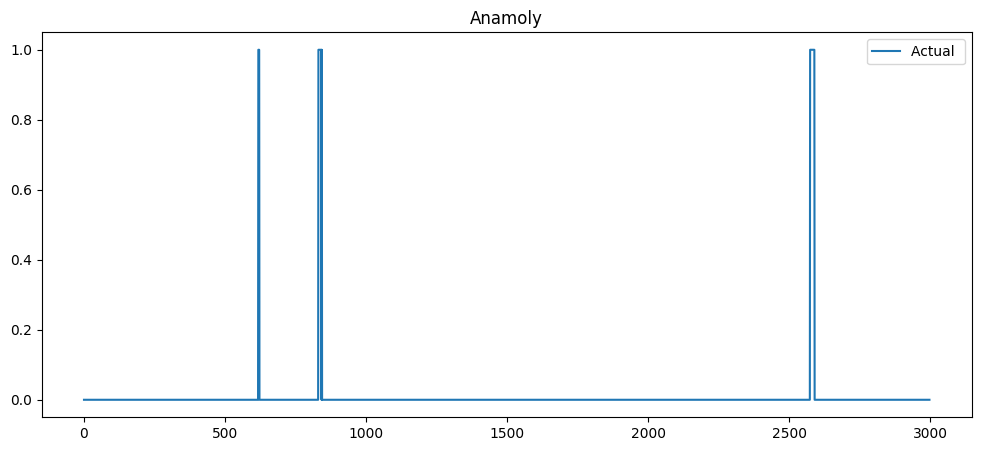

In [16]:
import matplotlib.pyplot as plt

ano_pred = model.predict(X_test)[2]
plt.figure(figsize=(12,5))
plt.plot(y_test_ano, label='Actual ')
# plt.plot(ano_pred[:100], label='Predicted ')
plt.title('Anamoly')
plt.legend()
plt.show()

In [40]:
# %%
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler

# Load & Preprocess
df = pd.read_csv(r"C:\Users\vvaib\Downloads\k8s_metrics.csv")
df.drop(columns=['API Latency', 'Pod Name'], inplace=True)

# Binary target for anomaly
df['Anomaly'] = (df['Node Status'] != "Running").astype(int)

# Normalize CPU & Memory for stability
scaler = MinMaxScaler()
df[['Memory Usage']] = scaler.fit_transform(df[[ 'Memory Usage']])

# Features for Isolation Forest
X = df[['Memory Usage']]
y_true = df['Anomaly']

# %%
# Train Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
y_pred = iso_forest.fit_predict(X)

# Convert predictions: -1 → anomaly (1), 1 → normal (0)
y_pred = np.where(y_pred == -1, 1, 0)

# %%
# Evaluation
print("✅ Accuracy:", accuracy_score(y_true, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))


✅ Accuracy: 0.9107982786803216

Confusion Matrix:
 [[53939  5305]
 [   43   667]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9992    0.9105    0.9528     59244
           1     0.1117    0.9394    0.1996       710

    accuracy                         0.9108     59954
   macro avg     0.5554    0.9249    0.5762     59954
weighted avg     0.9887    0.9108    0.9438     59954

